In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#time start: 0.0s
n_cell=931, n_gene=166


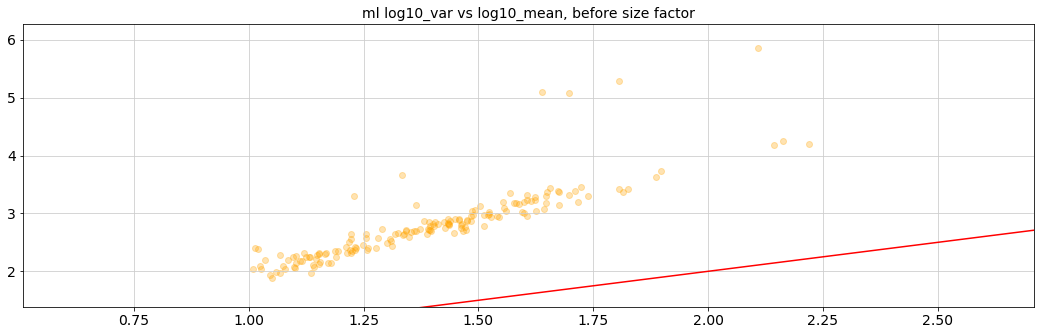

M1, sf=1.0000
M2, sf=1.0000
#time total: 0.4952s



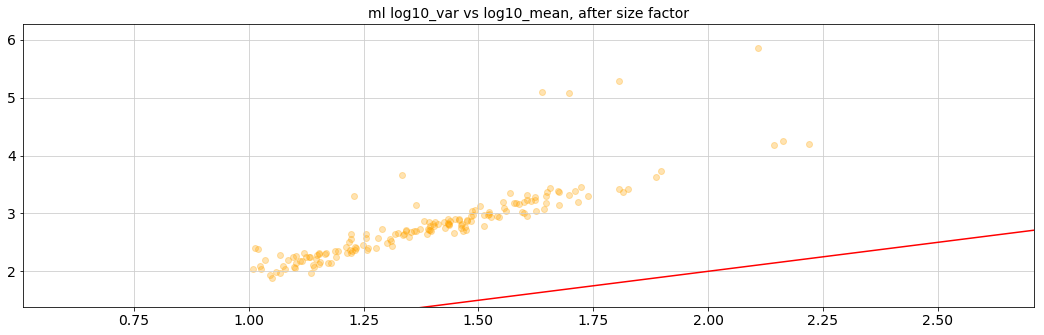

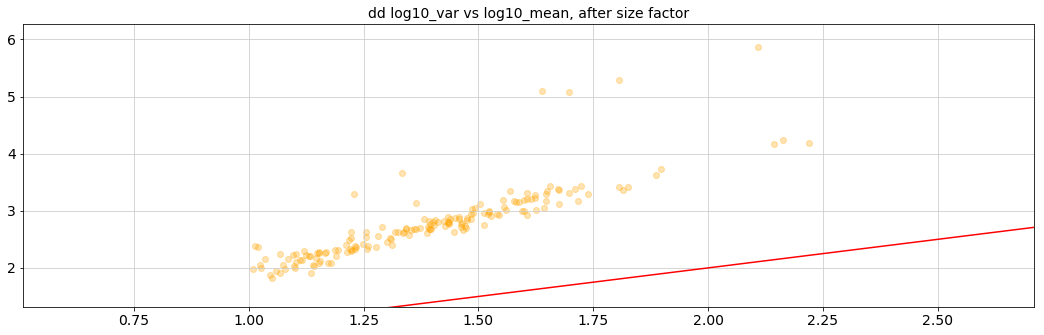

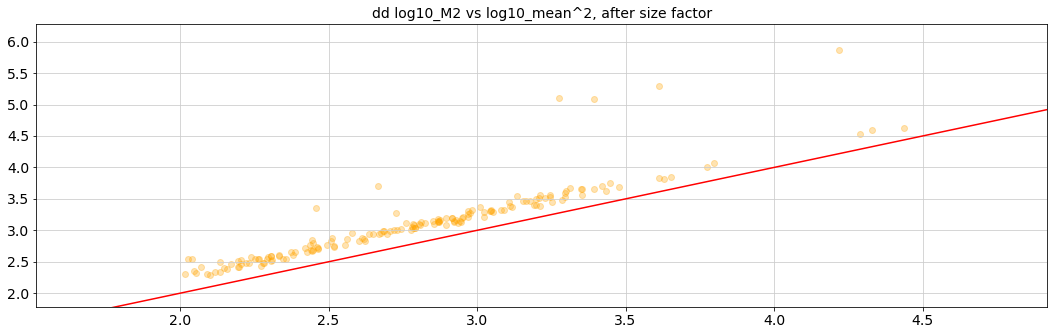

In [46]:
PC,PC_ml,gene_name = sd.dd_PC_anndata(data,verbose=True)

In [47]:
data_13m = load_10x_1_3mil()
sc.pp.filter_genes(data_13m,min_counts=5*data_13m.shape[0])

In [48]:
Nc,G = data_13m.shape
Nr = data_13m.X.sum()/Nc
B = Nc*Nr
Nr_bar = Nr/G
print(B,Nc,Nr,Nr_bar)

2386569984.0 1306127 1827.2112773107056 12.100736935832487


In [49]:
B_sub_list = [int(B/10000),int(B/5000),int(B/2000),int(B/1000)]
param=[]
for B_sub in B_sub_list:
    for Nr_bar in [0.1,0.2,0.5,1,2,3,4,5,8,10]:
        param.append((B_sub,Nr_bar,Nr_bar*G,int(B_sub/Nr_bar/G)))

In [50]:
data_subsamp = {}
for i in range(len(param)):
    _,Nr_bar_,Nr_,Nc_ = param[i]
    data_subsamp[param[i]]=sd.subsamp_anndata(data_13m,Nr_,Nc_)


#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (15805, 151)
#time sub-sample cells: 1.2372s
## 5000 cells processed
## 10000 cells processed
## 15000 cells processed
#time sub-sample counts: 21.3456s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (7902, 151)
#time sub-sample cells: 0.3385s
## 5000 cells processed
#time sub-sample counts: 11.1017s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (3161, 151)
#time sub-sample cells: 0.2108s
#time sub-sample counts: 4.5874s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (1580, 151)
#time sub-sample cells: 0.1785s
#time sub-sample counts: 2.3026s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (790, 151)
#time sub-sample cells: 0.1874s
#time sub-sample counts: 1.1229s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (526, 151)
#time sub-sample cells: 0.1589s
#time sub-sample counts: 1.1554s

#

#time sub-sample counts: 2.9484s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (1580, 151)
#time sub-sample cells: 0.3885s
#time sub-sample counts: 3.4346s



In [61]:
gamma_c = sd.sf(data_13m,verbose=False)
PC,PC_ml,gene_name = sd.dd_PC_anndata(data_13m,gamma_c=gamma_c,verbose=False)
# M,M_ml,gene_list = sd.dd_moment_anndata(data_13m,gamma_c=gamma_c,verbose=False)

In [62]:
PC_sub,PCml_sub = {},{}
for key in data_subsamp.keys():
    gamma_c = sd.sf(data_subsamp[key],verbose=False)
    PC_sub[key],PCml_sub[key],_ = sd.dd_PC_anndata(data_subsamp[key],gamma_c=gamma_c,verbose=False)

In [63]:
err_list_tot_ = {}
err_list_ml_tot_ = {}
Nr_bar_list_tot_ = {}
Nc_list_tot_ = {}

for B_sub in B_sub_list:
    err_list_ = []
    err_list_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            PC_sub_ = PC_sub[key]
            PCml_sub_ = PCml_sub[key]
            err_list_.append(np.log10(np.mean((PC_sub_-PC)**2)))
            err_list_ml_.append(np.log10(np.mean((PCml_sub_-PC)**2)))
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            
    err_list_ = np.array(err_list_)
    err_list_ml_ = np.array(err_list_ml_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_list_ = err_list_[sort_idx]
    err_list_ml_ = err_list_ml_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
            
    err_list_tot_[B_sub] = err_list_
    err_list_ml_tot_[B_sub] = err_list_ml_
    Nr_bar_list_tot_[B_sub] = Nr_bar_list_
    Nc_list_tot_[B_sub] = Nc_list_

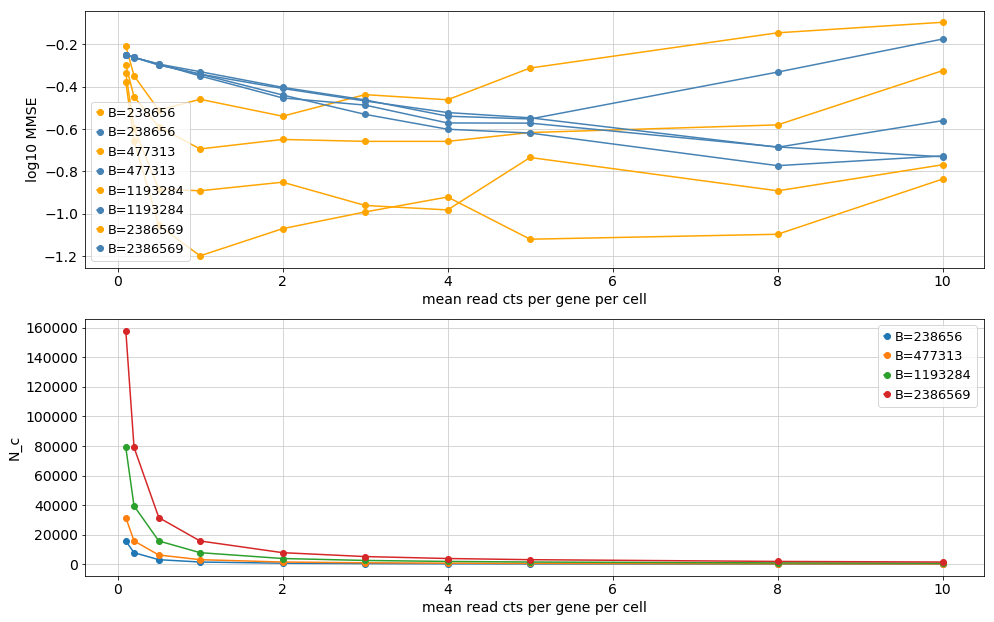

In [66]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_tot_[B_sub],marker='o',label='B=%d'%B_sub,color='orange')
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_ml_tot_[B_sub],marker='o',label='B=%d'%B_sub,color='steelblue')
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()

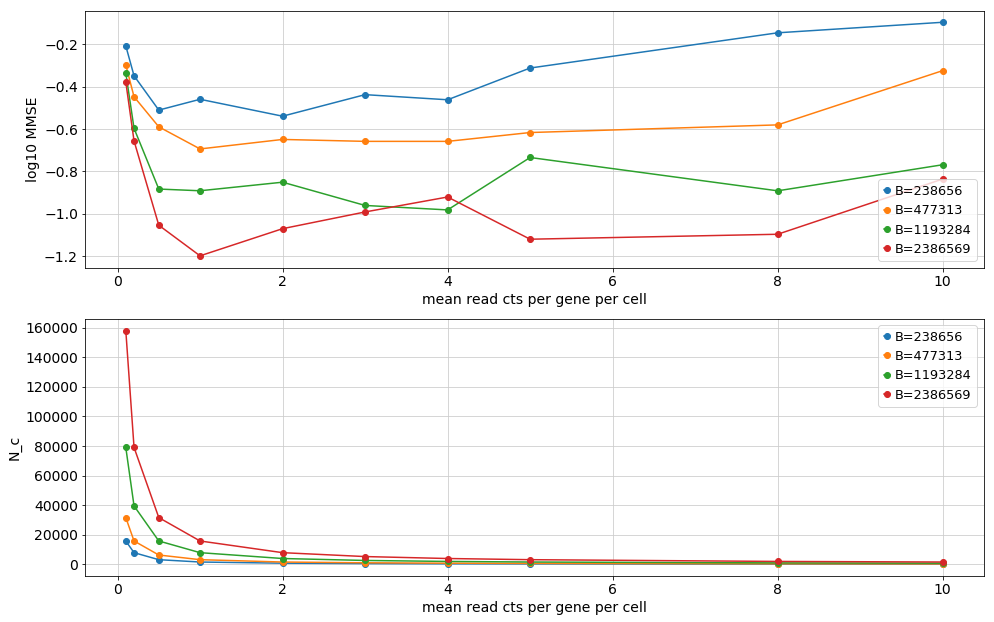

In [64]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()

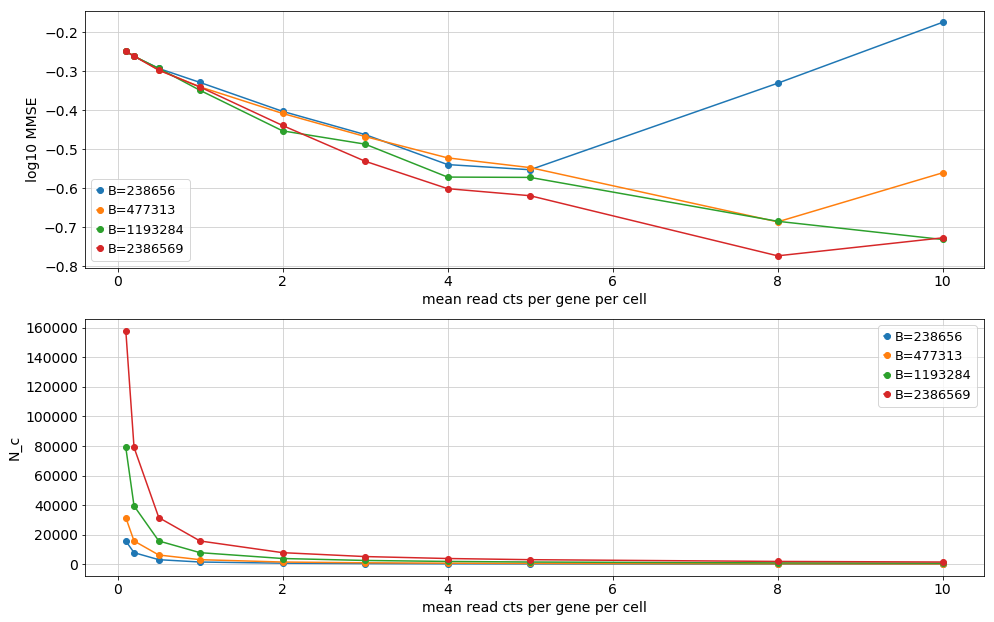

In [65]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_ml_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()